In [1]:
from constants_balloon import ρinterp, Pinterp, Ginterp, Tinterp
from scipy import interpolate
import numpy as np

In [2]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, setsolvefor
from datastructures.execution import edges_from_components
from datastructures.graphutils import namefromsympy, dfs_tree, SOLVER, VAR, COMP, nested_sources, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver
from datastructures.nestedgraph import root_sources
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.assembly import build_archi
import openmdao.api as om
from datastructures.api import evalexpr

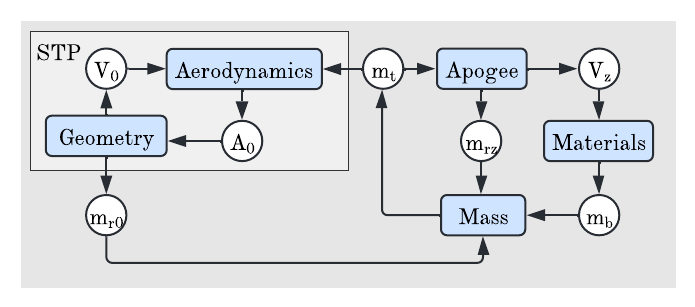

# General

In [3]:
model = Model(rootname='root')
m = model.root
idbyname = True
#m = addsolver(r)
z = Var('z', 30, unit='km')
R = Par('R', 287.05, 'J/kg/K')
alpha = Par(r'\alpha', 1)

# Apogee

In [4]:
apogee = addsolver(m, name='apogee', idbyname=idbyname)
pz = adda(apogee, 'p_z', lambda z: Pinterp(z), (z,), unit='Pa') # input assumed to be SI base (i.e. meter)
Tz = adda(apogee, 'T_z', lambda z: Tinterp(z), (z,), unit='K') # is in Kelvin already
gz = adda(apogee, 'g_z', lambda z: Ginterp(z), (z,), unit='m/s^2') # is in Kelvin already
rhoz = adda(apogee, r'\rho_z', pz/(R*Tz))
k = Par('k', 1.38064852e-23, 'J/K')
mm_He = Par('M_{He}', 6.64e-27, 'kg')
mm_H2 = Par('M_{H2}', 1.66e-27, 'kg')
rho_LGz = adda(apogee, r'\rho_{LGz}', pz*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tz))
m_t = Var('m_t', unit='kg')
W_z = adda(apogee, 'W_z', gz*m_t, unit='N')
L_z = adda(apogee, 'L_z', W_z, unit='N')
V_z = adda(apogee, 'V_z', L_z/(gz*rhoz))
mrz = adda(apogee, 'm_{rz}', V_z*rho_LGz)

# Materials

In [5]:
materials = addsolver(m, name='materials', idbyname=idbyname)
rz = adda(materials, 'r_z', (3*V_z/(4*np.pi))**(1/3), unit='m', forceunit=True)
hz = adda(materials, 'h_z', 2*(3/2)*rz)
p = Par('p', 8/5) #some parameter
S = adda(materials, 'S', 4*np.pi*(((rz**2)**p+2*abs(rz)**p*(abs(hz)/2)**p)/3)**(1/p))
t_LLDPE = Par('t_S', 25.4e-6*1, 'm')
rho_LLDPE = Par(r'\rho_S', 925, 'kg/m^3')
m_b = adda(materials, 'm_b', 2*(3/2)*S*t_LLDPE*rho_LLDPE)

# Mass budget

In [6]:
m_b = Var('m_b', unit='kg')

In [7]:
mass = addsolver(m, name='mass', idbyname=idbyname)
m_vhc = Par('m_v', 4545, 'kg')
m_parafoil = Par('m_p', 500., 'kg')
mr0 = Var('m_{r0}', unit='kg')
m_l = adda(mass, 'm_l', lambda m1,m2: max(m1,m2), (mrz, mr0), unit='kg')
adda(mass, m_t, m_vhc+m_parafoil+m_l+m_b);

# Balloon at STP

## Aerodynamics

In [8]:
aero = addsolver(m, name='aerodynamics', idbyname=idbyname)
V_0 = Var('V_0', unit='m^3')
g = Par('g', Ginterp(0), unit='m/s^2')
rho_0 = Par(r'\rho_0', ρinterp(0), 'kg/m^3')
W_0 = adda(aero, 'W_0', g*m_t, unit='N')
L_0 = adda(aero, 'L_0', g*rho_0*V_0, unit='N')
D = adda(aero, 'D', lambda L_0, W_0: max(L_0-W_0,0), (L_0,W_0), unit='N') 
C_D = Par('C_D', 0.47)
vr = Var('v', 6, 'm/s')
A_0 = adda(aero, 'A_0', 2*D/(C_D*rho_0*vr**2))

## Geometry

In [9]:
geom = addsolver(m, name='geometry', idbyname=idbyname)
r_0 = adda(geom, 'r_0', 1/np.pi*A_0**0.5, unit='m')
adda(geom, V_0, 4/3*np.pi*r_0**3, unit='m^3')
rho_He = Par(r'\rho_{He}', 0.1786, 'kg/m^3')
rho_H2 = Par(r'\rho_{H2}', 0.08988, 'kg/m^3')
rho_LG0 = adda(geom, r'\rho_{LG0}', alpha*rho_He+(1-alpha)*rho_H2)
adda(geom, mr0, V_0*rho_LG0)           

m_{r0}

# Visualize model

In [10]:
nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()

In [11]:
from datastructures.graphutils import draw_graph_graphical_props, Node
from datastructures.nestedgraph import build_typedgraph

In [12]:
from representations import draw

In [13]:
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

In [14]:
graphs = build_typedgraph(edges, tree, nodetyperepr)

In [16]:
# node = Node('geometry', SOLVER)
# (list(graphs['root'].predecessors(node)), list(graphs['root'].neighbors(node)))

In [17]:
# var_names = [elt for elt in G.nodes() if elt.nodetype==VAR]
# node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
# draw(graphs['root'], node_shape='b', prog='circo', latexlabels=False, figsize=(10,10));

In [18]:
from datastructures.rendering import render_incidence

In [19]:
from datastructures.graphutils import namefromid

In [20]:
nodetyperepr2 = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc2 = namefromid(nodetyperepr2)

In [21]:
Ein, Eout, Rin = edges

In [22]:
Ein_noparam = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Ein.items()}
edges_noparam = Ein_noparam, Eout, Rin

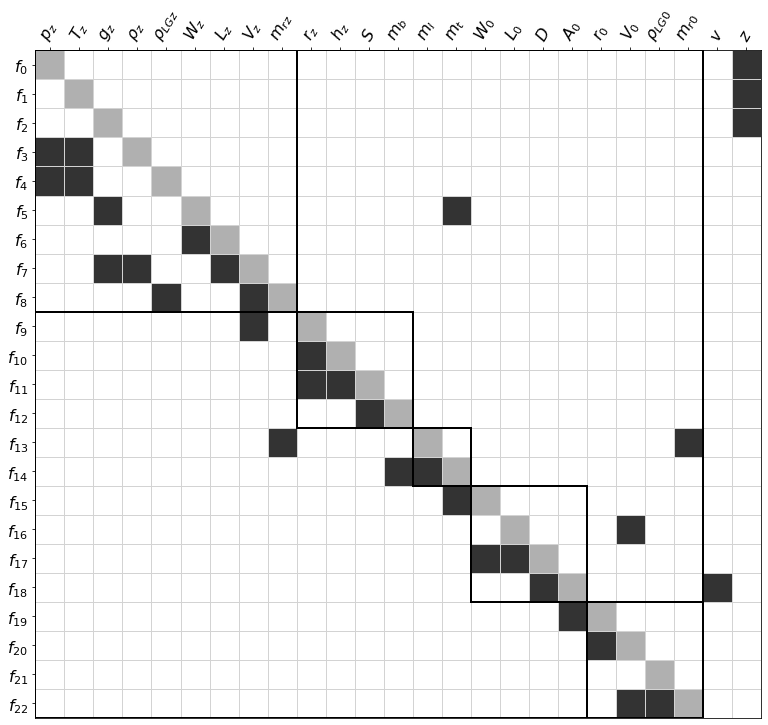

In [23]:
_, ax = render_incidence(edges_noparam, tree, namingfunc2, figsize=(13,13))

In [24]:
import matplotlib.pyplot as plt

In [25]:
# plt.sca(ax)
# plt.savefig('balloon_naive.png', dpi=600, bbox_inches='tight')

In [168]:
from datastructures.tearing import min_arc_set, min_arc_set_assign, dir_graph
import networkx as nx
from collections import OrderedDict

In [28]:
nodetyperepr3 = {VAR: '{}', COMP: '{}', SOLVER: '{}'}

In [29]:
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr3)

In [116]:
eqns = {node.name for node in G.nodes() if node.nodetype == COMP}
neqns = max(eqns)+1

In [117]:
vars_no_pars = {var for key,var in model.idmapping.items() if not var.always_input}

In [118]:
vrs2idx = {str(var):idx+neqns for idx,var in enumerate(vars_no_pars)}

In [119]:
avrs = vrs2idx.values()

In [120]:
graph_edges_minassign = [(key.name, vrs2idx[str(var)]) if key.nodetype==COMP else (vrs2idx[str(key)], var.name) for key,var in G.edges() if str(key) in vrs2idx or str(var) in vrs2idx]

In [30]:
outset = {nodetyperepr3[COMP].format(key): var[0] for key,var in Eout.items()}

In [31]:
from datastructures.graphutils import all_variables

In [108]:
vrs = {str(node) for node in G.nodes() if node.nodetype == VAR}
eqns = {str(node) for node in G.nodes() if node.nodetype == COMP}

In [109]:
graph_edges = [(str(key), str(var)) for key,var in G.edges()]

In [34]:
_, elimset = min_arc_set(graph_edges, outset, vrs, eqns)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [134]:
edges_left_right = list(dir_graph(graph_edges_minassign, eqns, {}))
xsol,m = min_arc_set_assign(edges_left_right, avrs, eqns)

In [158]:
selected = tuple((right, left) for left, right in edges_left_right if xsol[left, right] > 0.5)
D = nx.DiGraph(dir_graph(edges_left_right, eqns, selected))

In [163]:
minassign_order = sort_scc(D, lambda x: x in eqns)

In [170]:
Ftree_mina = OrderedDict([(next(iter(comp)),'root') for comp in minassign_order])

In [202]:
tree_mina = Ftree_mina, dict(), tree[2]

In [135]:
sum(xsol.values())

23.0

In [142]:
idx2vrs = {var:key for key,var in vrs2idx.items()}

In [145]:
Eout

{0: ('p_z',),
 1: ('T_z',),
 2: ('g_z',),
 3: ('\\rho_z',),
 4: ('\\rho_{LGz}',),
 5: ('W_z',),
 6: ('L_z',),
 7: ('V_z',),
 8: ('m_{rz}',),
 9: ('r_z',),
 10: ('h_z',),
 11: ('S',),
 12: ('m_b',),
 13: ('m_l',),
 14: ('m_t',),
 15: ('W_0',),
 16: ('L_0',),
 17: ('D',),
 18: ('A_0',),
 19: ('r_0',),
 20: ('V_0',),
 21: ('\\rho_{LG0}',),
 22: ('m_{r0}',)}

In [154]:
from itertools import chain

In [199]:
Eout_minassign = {}
Ein_minassign = {}
for comp,var in selected:
    varname = idx2vrs[var]
    Eout_minassign[comp] = (varname,)
    Ein_minassign[comp] = tuple(elt for elt in chain(Ein[comp],Eout[comp]) if elt!=varname)
Ein_minassign_np = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Ein_minassign.items()}

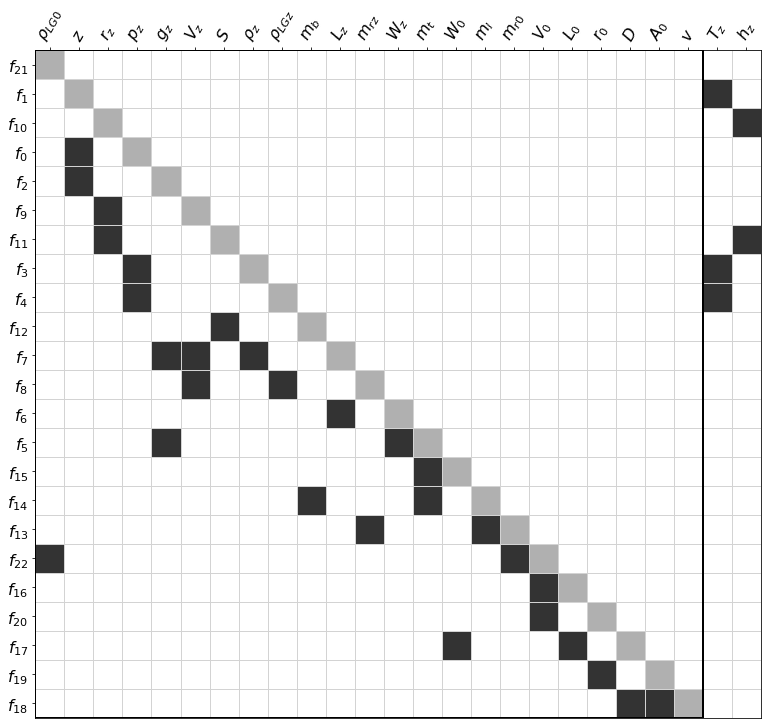

In [203]:
_, ax = render_incidence((Ein_minassign_np, Eout_minassign, dict()), tree_mina, namingfunc2, figsize=(13,13))

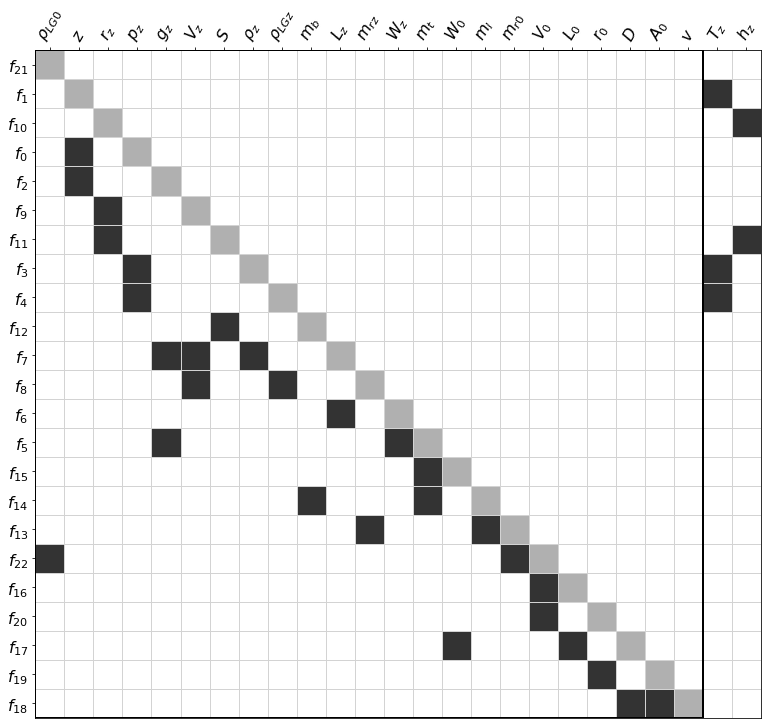

In [204]:
plt.sca(ax)
plt.savefig('balloon_restructured.png', dpi=600, bbox_inches='tight')

In [34]:
elimset

{'20', '5'}

In [49]:
edges, tree = model.generate_formulation()

In [50]:
nodetyperepr4 = {VAR: '{}', COMP: 'f{}', SOLVER: '{}'}
G2 = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr4)

In [51]:
elimedges = [(Node(int(elt),COMP,nodetyperepr4), Node(outset[elt], VAR,nodetyperepr4)) for elt in elimset]

In [52]:
elimedges

[(f17, D), (f14, m_t)]

In [53]:
G2.remove_edges_from(elimedges)

In [54]:
merge_order = sort_scc(G2)

In [55]:
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 2)

In [56]:
from collections import OrderedDict

In [57]:
Ftree, Stree, Vtree = ntree
Ftree = OrderedDict([(key, 'solver') for key,var in Ftree.items()])

In [62]:
Einn, Eoutn, Rinn = nedges
Ein_noparamn = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Einn.items()}
for comp,out in elimedges:
    Eoutn[comp.name] = (None,) 
    Rinn[comp.name] = (str(out),)
    Vtree[str(out)] = 'solver'
    Stree = {'solver':'root'}
edges_noparamn = Ein_noparamn, Eoutn, Rinn
ntree = Ftree, Stree, Vtree

In [63]:
order = order_from_tree(Ftree, Stree, Eoutn, includesolver=False, mergeendcomp=False)

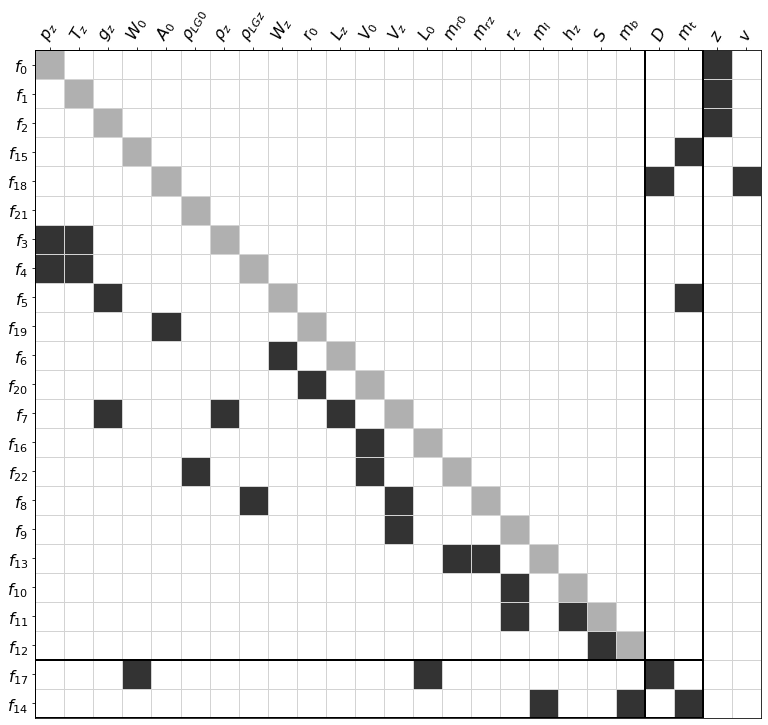

In [64]:
_, ax = render_incidence(edges_noparamn, ntree, namingfunc2, figsize=(13,13), displaysolver=True)

# Solve

In [18]:
from datastructures.graphutils import namefromsympy

In [19]:
ordered_tree = tree
ordered_edges = edges

In [20]:
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options['root'] = {'solver': 'N', 'maxiter':20}
# solvers_options['apogee'] = {'solver': 'GS', 'maxiter':20}
# solvers_options['materials'] = {'solver': 'GS', 'maxiter':20}
# solvers_options['mass'] = {'solver': 'GS', 'maxiter':20}
# solvers_options['aerodynamics'] = {'solver': 'GS', 'maxiter':20}
# solvers_options['geometry'] = {'solver': 'GS', 'maxiter':20}
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [22]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [23]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [25]:
prob.set_val('V_0', 10000)

In [26]:
prob.run_model()


====
root
====
NL: Newton Converged in 5 iterations


# Show results

In [27]:
from datastructures.postprocess import print_inputs, print_outputs

In [28]:
print_outputs(model, prob, namingfunc)

,0,1,2
0,p_z,1197,Pa
1,T_z,226.51,K
2,g_z,9.715,m/s²
3,\rho_z,0.018,kg/m³
4,\rho_{LGz},0.003,kg/m³
5,W_z,9.443×10⁴,N
6,L_z,9.443×10⁴,N
7,V_z,5.280×10⁵,m³
8,m_{rz},1341.833,kg
9,r_z,50.139,m


In [29]:
for key,var in model.comp_by_var.items():
    key.varval = prob.get_val(namingfunc(key.varid, VAR))[0]
    key.assumed = {key2: prob.get_val(namingfunc(key2.varid, VAR))[0] for key2,var2 in key.assumed.items()}

In [35]:
evalexpr(m_b+m_vhc+m_l+m_parafoil)

dummy

In [34]:
m_t

m_t

In [38]:
namingfunc('W_0', VAR)

'W_0'